# ab[x] toolkit: tutorial
The ab[x] toolkit contains three primary tools:
  * **abstar**, which performs germline assignment and primary sequence annotation
  * **abutils**, which provides programming primitives and commonly used functions like clustering and alignment
  * **abcloud**, for launching, configuring and managing clusters of compute instances on Amazon's cloud platform (AWS)  
  
In this tutorial, we're going to go over the interactive use of abstar and abutils. You can also run abstar from the command line, which is definitely the preferred use when processing a large number of sequences (more than a few thousand). 

In [1]:
from pprint import pprint
from abutils.core.sequence import Sequence
%matplotlib inline

## Section 1: File I/O

One of the core primitives used in the ab[x] toolkit is the `Sequence` object. It's how we represent and work with antibody sequences. The ab[x] toolkit (via abutils) has a few utilities for reading files containing sequence data, resulting in lists of Sequence objects. For this tutorial, we're going to look at two different file types that we use commonly with abstar: FASTA and JSON. These two file types encode different types of information:
  * **FASTA** files encode just the raw sequence data, and are formatted as follows:<br>
    \>Sequence name<br>
    ATGCATGCATGCATGCATGCATGCATGCATGC
    
  * **JSON** files contain abstar annotated data, and are formatted as a series of key/value pairs (we'll look at data like that later)

We're going to start by reading a FASTA file containing a few hundred HIV broadly neutralizing antibodies (bnAbs).

#### Reading FASTA files
Using the `read_fasta()` function, we simply provide a path to the FASTA file:

In [2]:
from abutils.core.sequence import read_fasta
fasta_seqs = read_fasta('./data/hiv_bnabs.fasta')

In [3]:
print(f'Number of FASTA sequences loaded: {len(fasta_seqs)}\n')

Number of FASTA sequences loaded: 459



  
  
Great, so now we have a list of several hundred Sequence objects. Sequence objects contain several useful properties and functions. For example, we can get the sequence ID using the `id` property:

In [4]:
f = fasta_seqs[0]
print(f'{f.id}\n')

10E8_JX645769_Homo_sapiens_anti-HIV_immunoglobulin_isolate_10E8_heavy_chain_variable_region_mRNA,_partial_cds



  
  
We can access the actual sequence information using the `sequence` property:

In [5]:
print(f.sequence)

GAGGTGCAGCTGGTGGAGTCTGGGGGAGGCTTGGTGAAGCCTGGAGGATCCCTTAGACTCTCATGTTCAGCCTCTGGTTTCGACTTCGATAACGCCTGGATGACTTGGGTCCGCCAGCCTCCAGGGAAGGGCCTCGAATGGGTTGGTCGTATTACGGGTCCAGGTGAAGGTTGGTCAGTGGACTATGCTGCACCCGTGGAAGGCAGATTTACCATCTCGAGACTCAATTCAATAAATTTCTTATATTTGGAGATGAACAATTTAAGAATGGAAGACTCAGGCCTTTACTTCTGTGCCCGCACGGGAAAATATTATGATTTTTGGAGTGGCTATCCGCCGGGAGAAGAATACTTCCAAGACTGGGGCCGGGGCACCCTGGTCACCGTCTCCTCA


<br>
We can select a subbset of the sequence using normal slicing syntax:

In [6]:
print(f[:10])

GAGGTGCAGC


#### Reading JSON files
Because FASTA files contain unannotated sequence data, the amount of information contained in those Sequence objects is somewhat limited. If you have some data that has already been annotated by abstar, those sequences will be stored in JSON files and can be read in a similar fashion. Let's read one of those next:

In [7]:
from abutils.core.sequence import read_json
json_seqs = read_json('./data/hiv_bnabs.json')

In [8]:
print(f'Number of JSON sequences loaded: {len(fasta_seqs)}\n')

Number of JSON sequences loaded: 459



The major difference between the Sequence objects we created from reading a FASTA file and the ones we just created by reading a JSON file is that the JSON-derived sequences include abstar annotations. We can access those using a dictionary-style lookup:

In [9]:
j = json_seqs[0]
print(f"{j['cdr3_aa']}\n")

ARTGKYYDFWSGYPPGEEYFQD



All of the annotations are stored in the `annotations` property, so you can see the entire set of annotations by calling that property:

In [10]:
# pprint(j.annotations)

#### Pair objects
Because real antibodies are composed of paired heavy and light chains and not individual sequences, the `Sequence` object may not be the best way to work with antibody sequence data when you have paired information. Accordingly, ab[x] also provides an object to represent antibody pairs, called the `Pair` object. ab[x] includes the `assign_pairs` function to pair sequences according to their name (for example, with 10X Genomics, the first portion of each seqeunce name contains the droplet barcode, so grouping sequences by the first portion of the sequence name is equicvalent to grouping by droplet). <br><br>In our case, we want to use the portion of the sequence name that preceeds the first underscore character, which we can specify using the `delim` keyword argument:

In [11]:
from abutils.core.pair import assign_pairs

pairs = assign_pairs(json_seqs, delim='_')
print(f'{len(pairs)}\n')

238



`Pair` objects are relatively flexible -- it doesn't have to contain just a single heavy and a single light chain. If you've worked with 10X Genomics data, you quickly realize that some droplets contain multiple heavy or multiple light chain sequences. Some droplets are missing either heavy or light chains. the `Pair` object can handle all of these situations without a problem. As you can see, only 220 of our `Pair` objects actually contain both heavy and light chains:

In [12]:
real_pairs = [p for p in pairs if p.is_pair]
print(f'{len(real_pairs)}\n')

220



## Section 2: The abstar API
Running abstar though the API is very simple. All you need to do is pass sequences as arguments. The sequences we read from the FASTA file will work nicely. There are a few hundred of them so this will take a few seconds:

In [13]:
import abstar
annotated_seqs = abstar.run(*fasta_seqs)

In [14]:
print(f'{len(annotated_seqs)}\n')

459



#### Making summary plots of annotated sequence data
Good. So we've essentially recreated the data we read from the JSON file using the abstar API. Now let's take a closer look at the sequence data. Abutils contains a few functions for generating summary plots of sequence data. Lets first look at the V, D and J use in heavy chain sequences. Note that for V and D genes, each gene is shown separately but the coloring is based on the gene family (for example, all IGHV1 genes are shown in read):

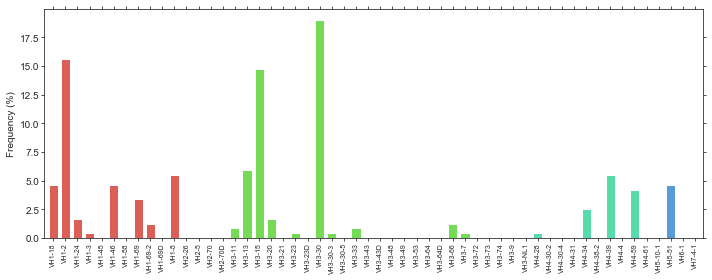

In [15]:
from abutils.plots.summary import germline_use_plot
germline_use_plot(annotated_seqs, gene='V', chain='heavy')

<br>
<br>
Now let's examine the CDR3 lengths. The sequences we're using here are HIV bnAbs, which are skewed toward very long HCDR3s (often >30 AA):

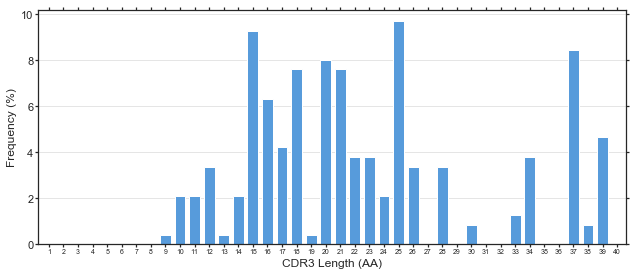

In [18]:
from abutils.plots.summary import cdr3_length_plot
cdr3_length_plot(annotated_seqs, chain='heavy')

## Section 3: Clustering and alignment

#### Clustering

Let's start by clustering our sequences. CD-HIT is the default clustering tool used by abutils, although we're migrating to use [vsearch](https://github.com/torognes/vsearch) in the near future. All we need to do is pass our annotated sequences to the cluster function:

In [46]:
from abutils.utils.cluster import cluster
clusters = cluster(json_seqs, threshold=0.92, quiet=True)

In [49]:
print(f'{len(clusters)}\n')

282



So our set of 459 sequences was clustered into 282 clusters, when using 92% identity as the threshold. Now lets find the largest cluster and take a closer look at those sequences.

In [51]:
largest_cluster = clusters.largest_cluster
print(f'{largest_cluster.size}\n')

15



Let's take a look at which sequences make up the cluster:

In [52]:
print('\n'.join(largest_cluster.ids))

PCT64-24F_MF565876_PCT64-24F-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-24G_MF565877_PCT64-24G-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-24H_MF565878_PCT64-24H-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35B_MF565880_PCT64-35B-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35C_MF565881_PCT64-35C-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35D_MF565882_PCT64-35D-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35E_MF565883_PCT64-35E-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35F_MF565884_PCT64-35F-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35G_MF565885_PCT64-35G-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35H_MF565886_PCT64-35H-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35I_MF565887_PCT64-35I-HC_anti-HIV_immunoglobulin_heavy_chain_variable_region
PCT64-35K_MF565889_PCT64-35K-HC_anti-HIV_immunoglobulin_heavy_chain_variable

#### Alignment
Next, lets make an alignment of all heavy chain sequences in the PCT64 lineage. First we need to get those sequences from our `annotated_seqs` dataset:

In [53]:
pct64_seqs = [s for s in annotated_seqs if all(['PCT64' in s.id, s['chain'] == 'heavy'])]
print(f'{len(pct64_seqs)}\n')

23



We're going to make a `dot_alignment`, which produces an alignment in which matches are shown as dots, with mismatches shown as the mismatched nucleotide (or amino acid). Before we start, however, let's truncate the names of our sequences, which are quite long. We only need the portion of the name that preceeds the first underscore:

In [54]:
for s in pct64_seqs:
    s.id = s.id.split('_')[0]
    s['seq_id'] = s.id

Dot alignments need to be made against a reference, and by default ab[x] will use the centroid of all of the sequences in the dot alignment. For our case, however, we'd like to use the least mutated sequence in the lineage, which is named `PCT64-18B`.

In [55]:
from abutils.utils.alignment import dot_alignment

dot_aln = dot_alignment(pct64_seqs, seq_field='vdj_aa', root='PCT64-18B')
print(dot_aln)

PCT64-18B  EVQLVESGGGLVKPGGSLRLSCVASGFTFSDAWMTWVRQAPGKGLEWVGHMRPIPEGGAIDYAAPVKGRFTISRDDSKKTLYLQMNSLKIEDTALYYCMTGVETKDFWGDDYGDYYDHYFIDVWGKGTTVTVS
PCT64-35S  ....................A..G.E....E......................TT....K....A.R.....A.....S..............GV........RG...S...SQH.NT.L.............
PCT64-35H  .......................G.E....E..................D...T.....KN..........V......S...............V........RG...S...SQH.NT.L.............
PCT64-35K  ............E..........G.E.A.........................T.....K...........V......S..............GV........AG...S.E.SQH.NT.L.............
PCT64-35N  ............E..........G.E.A.........................T.....K...........V......S..............GV........AG...S.E.SQH.NT.L.............
PCT64-35O  ............E..........G.E.A.........................T.....K...........V......S..............GV........AG...S.E.SQH.NT.L.............
PCT64-24G  .......................G.E.A.........................T.....K...........V......R...............V.........G...S...SQH.NS.